In [1]:
"""
Extension for disabling autoscrolling long output, which is super annoying sometimes
Usage:
    %load_ext disable_autoscroll
You can also put the js snippet below in profile_dir/static/js/custom.js
"""

from IPython.display import display, Javascript

disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""

def load_ipython_extension(ip):
    display(Javascript(disable_js))
    print ("autoscrolling long output is disabled")
    
load_ipython_extension(0)

<IPython.core.display.Javascript object>

autoscrolling long output is disabled


In [2]:
import pandas as pd
import scipy as sp 
import numpy as np
import itertools

import csv

#%matplotlib notebook
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib

import graphlab as gl

from sets import Set
import re

import urlparse
import datetime as dt

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
[WARNING] Unable to write current GraphLab Create license to /home/usr/.graphlab/config. Ensure that this user account                         has write permission to /home/usr/.graphlab/config to save the license for offline use.
[INFO] GraphLab Create v1.8.3 started. Logging: /tmp/graphlab_server_1459852601.log
[WARNING] Unable to create session in specified location: '/home/usr/.graphlab/artifacts'. Using: '/var/tmp/graphlab-usr/4078/tmp_session_80d347b4-a567-47f9-ba34-ff9bd53ce0ed'
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: DeprecationWarning: the sets module is deprecated


In [3]:
df = pd.read_csv("rfm_users_sorted_not_null.csv", sep=";")

df.columns = ["user_id", "clicks", "days", "price"]
df.shape

(55263, 4)

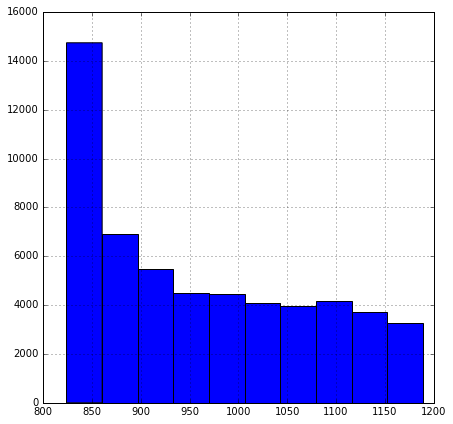

In [4]:
fig = plt.figure(figsize=(7,7))
fig = df["days"].hist()

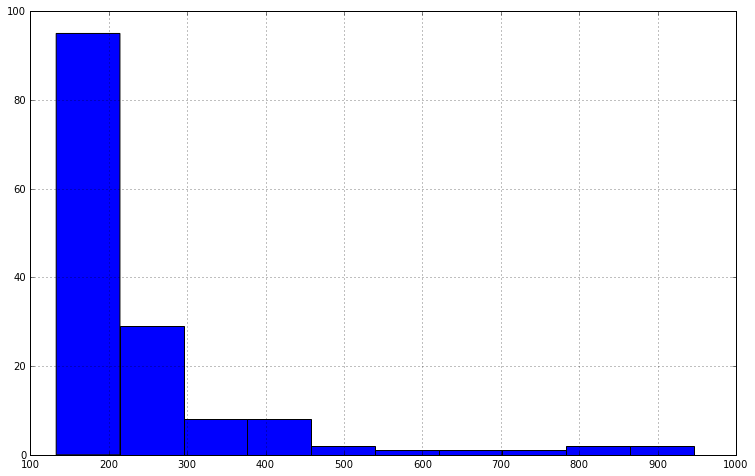

In [5]:
fig = plt.figure(figsize=(14,7))
fig = df.sort_values("clicks",ascending=0)[1:150]["clicks"].hist()
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.75, top=0.93, wspace=0.27, hspace=0.36)

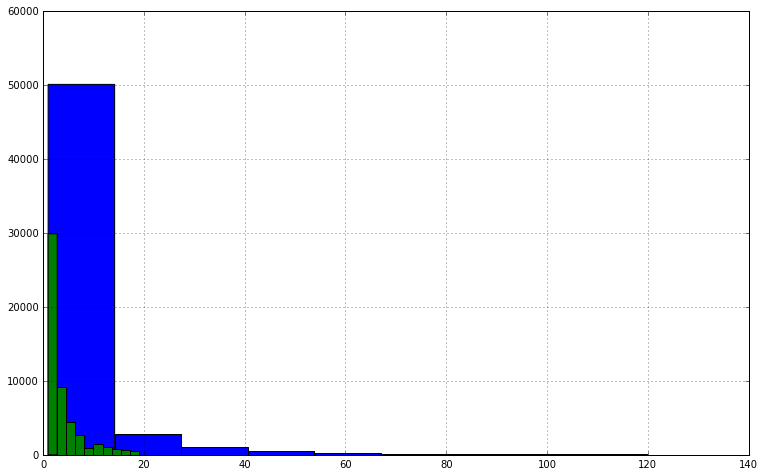

In [6]:
fig = plt.figure(figsize=(14,7))
fig = df.sort_values("clicks",ascending=0)[150:]["clicks"].hist()
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.75, top=0.93, wspace=0.27, hspace=0.36)
df[df["clicks"] < 20]["clicks"].hist()

Заметно, что большинство юзеров делают от 0 до 10-20 кликов. Посмотрим этот сегмент подробнее.

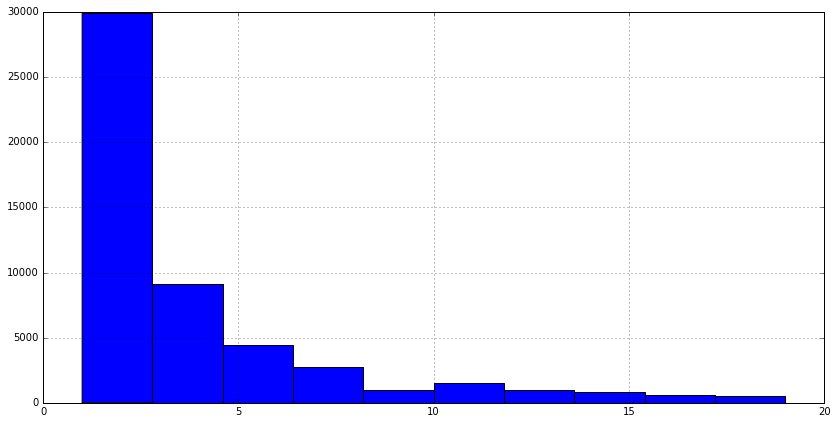

In [7]:
fig = plt.figure(figsize=(14,7))
fig = df[df["clicks"] < 20]["clicks"].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb89f221ad0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb89f037a50>]], dtype=object)

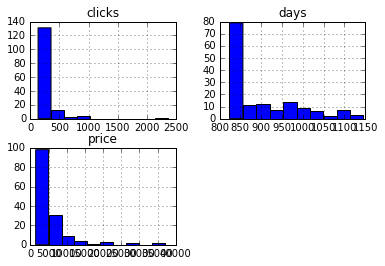

In [8]:
df.sort_values("clicks",ascending=0)[0:150][["clicks", "days", "price"]].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb89eea8a90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb89f347dd0>]], dtype=object)

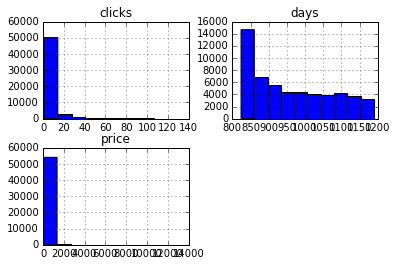

In [9]:
df.sort_values("clicks",ascending=0)[150:][["clicks", "days", "price"]].hist()

Заметно, что по количеству кликов есть несколько сегментов.

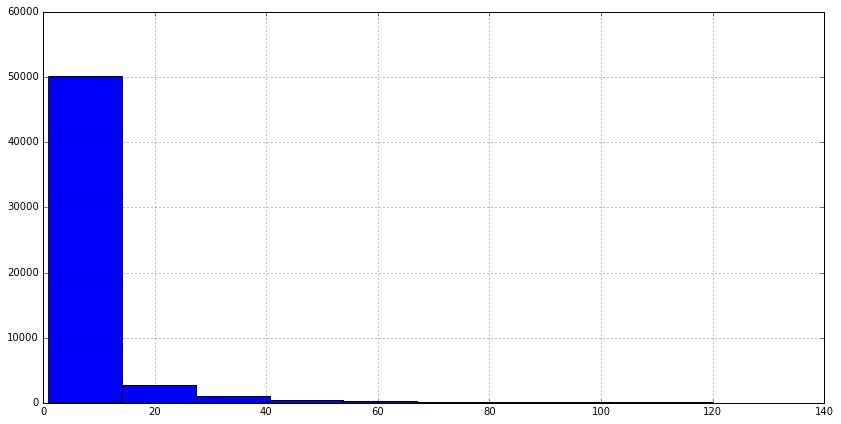

In [10]:
fig = plt.figure(figsize=(14,7))
fig = df.sort_values("clicks",ascending=0)[150:]["clicks"].hist()

In [11]:
df["days"].describe()

count    55263.000000
mean       960.901091
std        110.402973
min        824.000000
25%        857.000000
50%        937.000000
75%       1054.000000
max       1189.000000
Name: days, dtype: float64

# Попробуем разные способы binning (группировки?)

Посмотрим, что будет если разделить линейное пространство от максиума до минимума на равные интервалы

In [12]:
bins = np.linspace(df['price'].min(), df['price'].max(), 10)
df["P1"] = np.digitize(df['price'], bins)

bins = np.linspace(df['days'].min(), df['days'].max(), 10)
df["R1"] = np.digitize(df['days'], bins)

bins = np.linspace(df['clicks'].min(), df['clicks'].max(), 10)
df["F1"] = np.digitize(df['clicks'], bins)


df['R1'].unique(), df['P1'].unique(), df['F1'].unique()

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([ 1,  2,  3,  7,  4,  8, 10,  6,  9]),
 array([ 1,  2,  3, 10,  4]))

In [13]:
df[df['R1'] == 1].shape[0],  df[df['R1'] == 2].shape[0], df[df['R1'] == 3].shape[0]

(15678, 7233, 5839)

In [14]:
df[df['F1'] == 1].shape[0],  df[df['F1'] == 2].shape[0], df[df['F1'] == 3].shape[0]

(55223, 31, 4)

In [15]:
df[df['P1'] == 1].shape[0],  df[df['P1'] == 2].shape[0], df[df['P1'] == 3].shape[0]

(55129, 103, 18)

Похоже, что подходит только для времени. Или нужно увеличивать количество интервалов.

<h2>Попробуем разделить на персентили.</h2>

In [16]:
n_quantiles = 100
n_quantiles+=1

labels = map(str, np.arange(n_quantiles -1 ) +1 )

counts = []


for it in [("days", "R2"), ("clicks", "F2"), ("price", "P2")]:

    ser = df[it[0]]
    bins = pd.core.algorithms.quantile(np.unique(ser), np.linspace(0, 1, n_quantiles))
    result = pd.tools.tile._bins_to_cuts(ser, bins, include_lowest=True, labels=labels)    
    vc = result.value_counts()        
    counts.append(vc)
    df[it[1]] = result
    

for it in [("days", "R2_"), ("clicks", "F2_"), ("price", "P2_")]:

    ser = df[it[0]]
    bins = pd.core.algorithms.quantile(np.unique(ser), np.linspace(0, 1, n_quantiles))
    result = pd.tools.tile._bins_to_cuts(ser, bins, include_lowest=True)    
    vc = result.value_counts()
    print it,'\n', vc
    counts.append(vc)
    vc = result.value_counts()            
    df[it[1]] = result

('days', 'R2_') 
(827.65, 831.3]      2570
[824, 827.65]        2301
(838.6, 842.25]      1792
(834.95, 838.6]      1421
(845.9, 849.55]      1379
(842.25, 845.9]      1229
(849.55, 853.2]      1190
(856.85, 860.5]      1050
(831.3, 834.95]       936
(860.5, 864.15]       931
(853.2, 856.85]       879
(878.75, 882.4]       776
(867.8, 871.45]       749
(871.45, 875.1]       747
(893.35, 897]         739
(864.15, 867.8]       706
(882.4, 886.05]       682
(889.7, 893.35]       676
(907.95, 911.6]       665
(911.6, 915.25]       602
(922.55, 926.2]       585
(918.9, 922.55]       581
(875.1, 878.75]       576
(929.85, 933.5]       570
(940.8, 944.45]       563
(984.6, 988.25]       546
(933.5, 937.15]       545
(1039.35, 1043]       539
(980.95, 984.6]       523
(962.7, 966.35]       518
                     ... 
(1159.8, 1163.45]     377
(1105.05, 1108.7]     370
(1174.4, 1178.05]     369
(937.15, 940.8]       367
(1032.05, 1035.7]     367
(1072.2, 1075.85]     361
(1035.7, 1039.35]    

In [17]:
df["R2"] = df["R2"].values.astype(int)
df["F2"] = df["F2"].values.astype(int)
df["P2"] = df["P2"].values.astype(int)

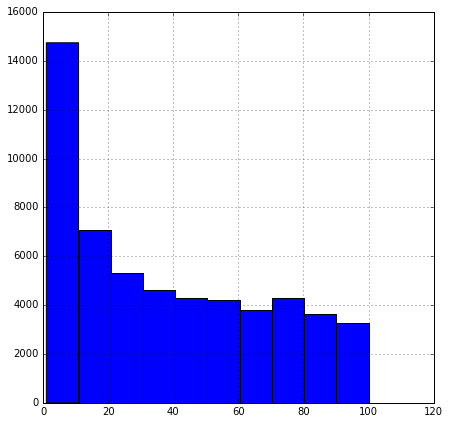

In [18]:
fig = plt.figure(figsize=(7,7))
fig = df["R2"].hist()

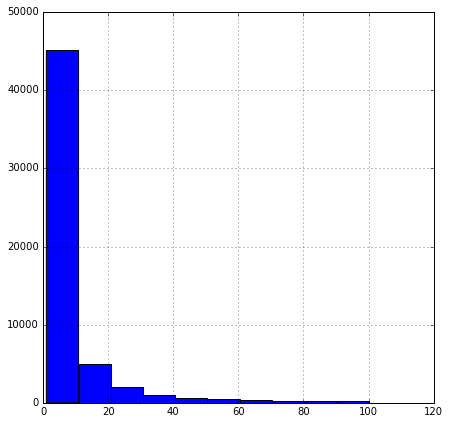

In [19]:
fig = plt.figure(figsize=(7,7))
fig = df["P2"].hist()

Если применить сортировку, то заметно, что у покупателей с высокими frequency и recency не всегда самая лучшая последняя дата покупок, с такими покупателями можно увеличить частоту контакта.

In [20]:
# ex1 = df.sort_values(["P2", "F2", "R2"], ascending=[0,0,0], )[:10][["R2", "F2", "P2"]]
# ex1.to_csv("ex1.csv")

In [21]:
df["months"] = df["days"] / 30

In [56]:
ex1 = df.sort_values(["P2", "F2", "R2"], ascending=[0,0,0])[:10][["months","R2", "F2", "P2"]]
ex1.to_csv("ex1.csv")

Более удовлетворительно.

In [23]:
df["months"] = df["days"] / 30

In [24]:
n_quantiles = 5
n_quantiles+=1

labels = map(str, np.arange(n_quantiles -1 ) +1 )

counts = []


for it in [("days", "R1"), ("clicks", "F1"), ("price", "P1")]:

    ser = df[it[0]]
    bins = pd.core.algorithms.quantile(np.unique(ser), np.linspace(0, 1, n_quantiles))
    result = pd.tools.tile._bins_to_cuts(ser, bins, include_lowest=True, labels=labels)    
    vc = result.value_counts()        
    counts.append(vc)
    df[it[1]] = result
    

for it in [("days", "R1_"), ("clicks", "F1_"), ("price", "P1_")]:

    ser = df[it[0]]
    bins = pd.core.algorithms.quantile(np.unique(ser), np.linspace(0, 1, n_quantiles))
    result = pd.tools.tile._bins_to_cuts(ser, bins, include_lowest=True)    
    vc = result.value_counts()
    print it,'\n', vc
    counts.append(vc)
    vc = result.value_counts()            
    df[it[1]] = result

('days', 'R1_') 
[824, 897]      21844
(897, 970]       9925
(970, 1043]      8540
(1043, 1116]     8072
(1116, 1189]     6882
dtype: int64
('clicks', 'F1_') 
[1, 48.4]         54239
(48.4, 95.8]        703
(95.8, 144.2]       195
(144.2, 216.8]       73
(216.8, 2356]        53
dtype: int64
('price', 'P1_') 
[5, 446.4]          50081
(446.4, 889.8]       3039
(889.8, 1416.2]      1056
(1416.2, 2312.6]      615
(2312.6, 37020]       472
dtype: int64


In [25]:
df.set_index("user_id")

,clicks,days,price,P1,R1,F1,R2,F2,P2,R2_,F2_,P2_,months,R1_,F1_,P1_
user_id,,,,,,,,,,,,,,,,
f120b615df2e1a8bcf6d793bdbbd503f,2.0,824,20.0,1,1,1,1,1,1,"[824, 827.65]","[1, 3.37]","[5, 27.07]",27.466667,"[824, 897]","[1, 48.4]","[5, 446.4]"
7a42e033e5cb95a03f689e822a16ad9b,1.0,824,209.0,1,1,1,1,1,10,"[824, 827.65]","[1, 3.37]","(203.63, 225.7]",27.466667,"[824, 897]","[1, 48.4]","[5, 446.4]"
8eae1c45d9195b869b255285c0e2da6d,4.0,824,127.0,1,1,1,1,2,6,"[824, 827.65]","(3.37, 5.74]","(115.35, 137.42]",27.466667,"[824, 897]","[1, 48.4]","[5, 446.4]"
3f51be06a90937eb91d1a6dc7fd67049,3.0,824,28.0,1,1,1,1,1,2,"[824, 827.65]","[1, 3.37]","(27.07, 49.14]",27.466667,"[824, 897]","[1, 48.4]","[5, 446.4]"
580268437067e3646b189a6647d40c3b,1.0,824,56.0,1,1,1,1,1,3,"[824, 827.65]","[1, 3.37]","(49.14, 71.21]",27.466667,"[824, 897]","[1, 48.4]","[5, 446.4]"
86c537f5d1251c644fed9f71360eac35,9.0,824,104.0,1,1,1,1,4,5,"[824, 827.65]","(8.11, 10.48]","(93.28, 115.35]",27.466667,"[824, 897]","[1, 48.4]","[5, 446.4]"
170f725b0a30a91e077950cf94127e4b,16.0,824,310.0,1,1,1,1,7,14,"[824, 827.65]","(15.22, 17.59]","(291.91, 313.98]",27.466667,"[824, 897]","[1, 48.4]","[5, 446.4]"
5c95466099af23021422627fe81dcebd,1.0,824,10.0,1,1,1,1,1,1,"[824, 827.65]","[1, 3.37]","[5, 27.07]",27.466667,"[824, 897]","[1, 48.4]","[5, 446.4]"
8a7a55cf275351bfcb241bb176c8a530,1.0,824,10.0,1,1,1,1,1,1,"[824, 827.65]","[1, 3.37]","[5, 27.07]",27.466667,"[824, 897]","[1, 48.4]","[5, 446.4]"


In [41]:
df["R1"] = df["R1"].values.astype(int)
df["F1"] = df["F1"].values.astype(int)
df["P1"] = df["P1"].values.astype(int)

In [47]:
df["F1"].unique()

array([1, 3, 2, 4, 5])

In [44]:
df["R1"].unique()

array([1, 2, 3, 4, 5])

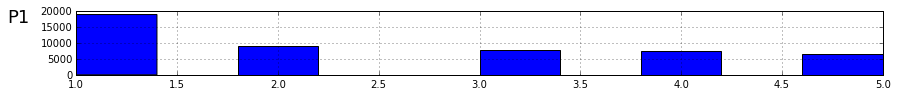

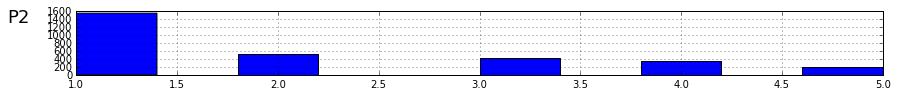

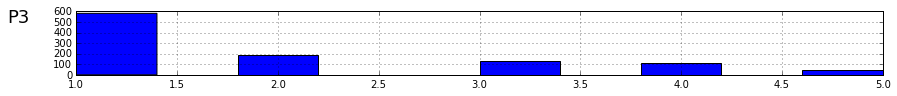

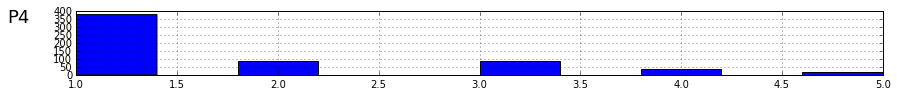

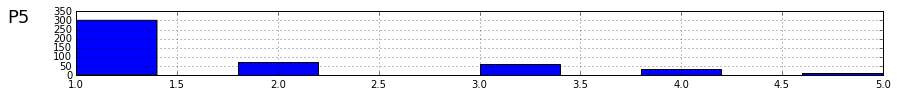

In [55]:
rng = np.arange(n_quantiles -1) +1

for it in rng:    
    fig = plt.figure(figsize=(16,1))
    plt.suptitle("P"+str(it), verticalalignment='top', horizontalalignment='left', x=-0.01,  fontsize=18)
    fig = df[df["P1"] == it]["R1"].hist()
    plt.subplots_adjust(left=0.05, bottom=0.05, right=0.75, top=0.93, wspace=0.27, hspace=0.36)
#     plt.savefig( 'graphs_months/' + str(it) + 'months.png')